# Graph and Graph Neural Network Basics

## Resources and References
- https://github.com/rasbt/machine-learning-book/tree/main/ch18 

In [2]:
from IPython.display import Image
%matplotlib inline

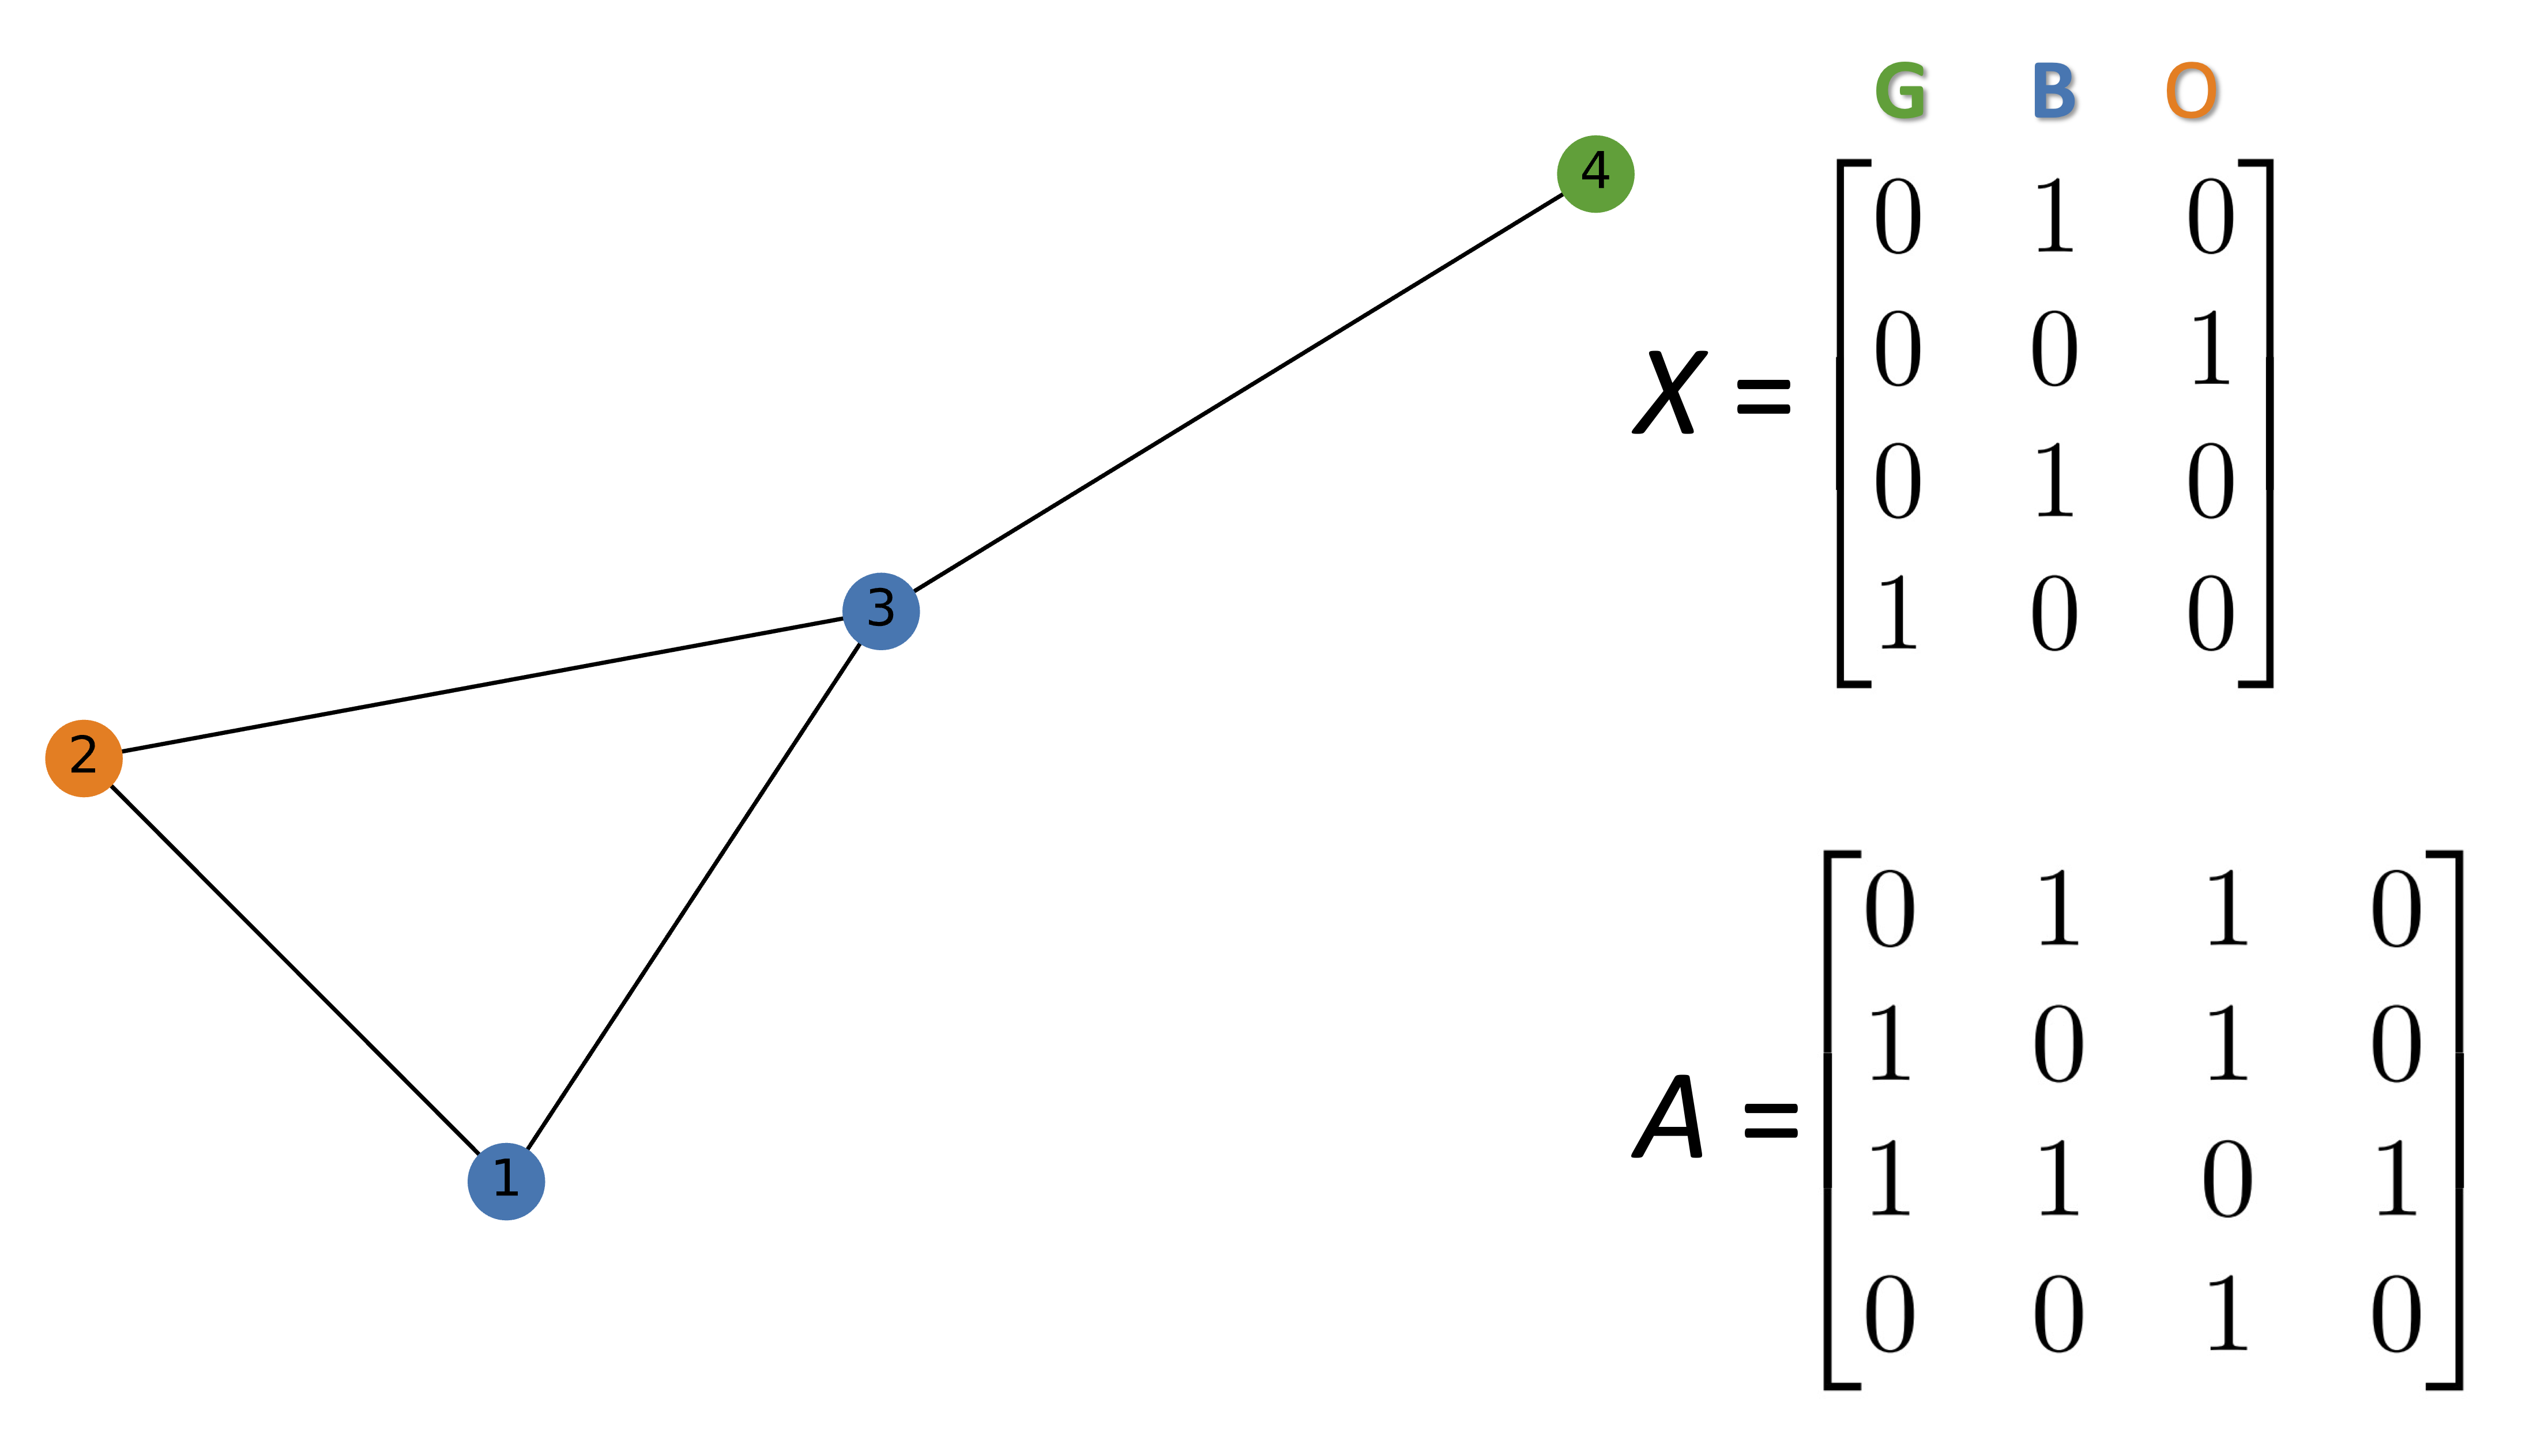

In [63]:
Image(filename="figure/18_06.png", width=700)

# Building a Graph

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

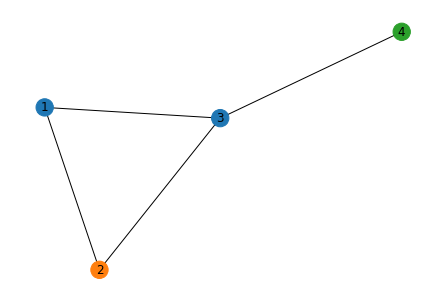

In [55]:
G = nx.Graph()

#Hex codes for colors if we draw graph
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"

G.add_nodes_from([
    (1, {'color':blue}),
    (2, {'color':orange}),
    (3, {'color':blue}),
    (4, {'color':green}),
    
])

G.add_edges_from([
    (1, 2),
    (1, 3),
    (2, 3),
    (3, 4)
])

color_attribute_of_G = nx.get_node_attributes(G, 'color').values()  # get the nodes color attribute value, a list of attribute values


nx.draw(G, with_labels=True, node_color=color_attribute_of_G)
plt.show()

## Adjaceny Matrix

In [54]:
A = np.asarray(nx.adjacency_matrix(G).todense())
A

array([[0, 1, 1, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 1],
       [0, 0, 1, 0]])

In [45]:
# feature_map  = {green : 0, blue:1, orange: 2} # map a color to a index
# color_attribute_of_G = nx.get_node_attributes(G, 'color').values()  # get the nodes color attribute value, a list of attribute values
# color_to_idx = [feature_map[v] for v in color_attribute_of_G] # get the 1d-array with the numeric index for the node color attribute
# one_hot_encoding = np.zeros([len(color_to_idx), len(feature_map)])   # array of size -> nodes_size * no_of_features
# one_hot_encoding[range(len(color_to_idx)), color_to_idx] = 1  # rows and columns on which we want 1
# one_hot_encoding

## Get Feature of the Graph

In [42]:
def get_graph_feature_matrix(G, feature_map: dict):

    color_attribute_of_G = nx.get_node_attributes(G, 'color').values()  # get the nodes color attribute value, a list of attribute values
    color_to_idx = [feature_map[v] for v in color_attribute_of_G] # get the 1d-array with the numeric index for the node color attribute
    one_hot_encoding = np.zeros([len(color_to_idx), len(feature_map)])   # array of size -> nodes_size * no_of_features
   
    one_hot_encoding[range(len(color_to_idx)), color_to_idx] = 1  # passing, rows and columns on which we want 1

    return one_hot_encoding

In [56]:
feature_map  = {green : 0, blue:1, orange: 2} # map a color to a index
X = get_graph_feature_matrix(G, feature_map)
X

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

## The X and A

In [61]:
print(X)
print()
print(A)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


# Learning About graph

In [92]:
D = nx.degree_mixing_matrix(G, normalized=False)
D

array([[0., 0., 1.],
       [0., 2., 2.],
       [1., 2., 0.]])

# Simple GNN

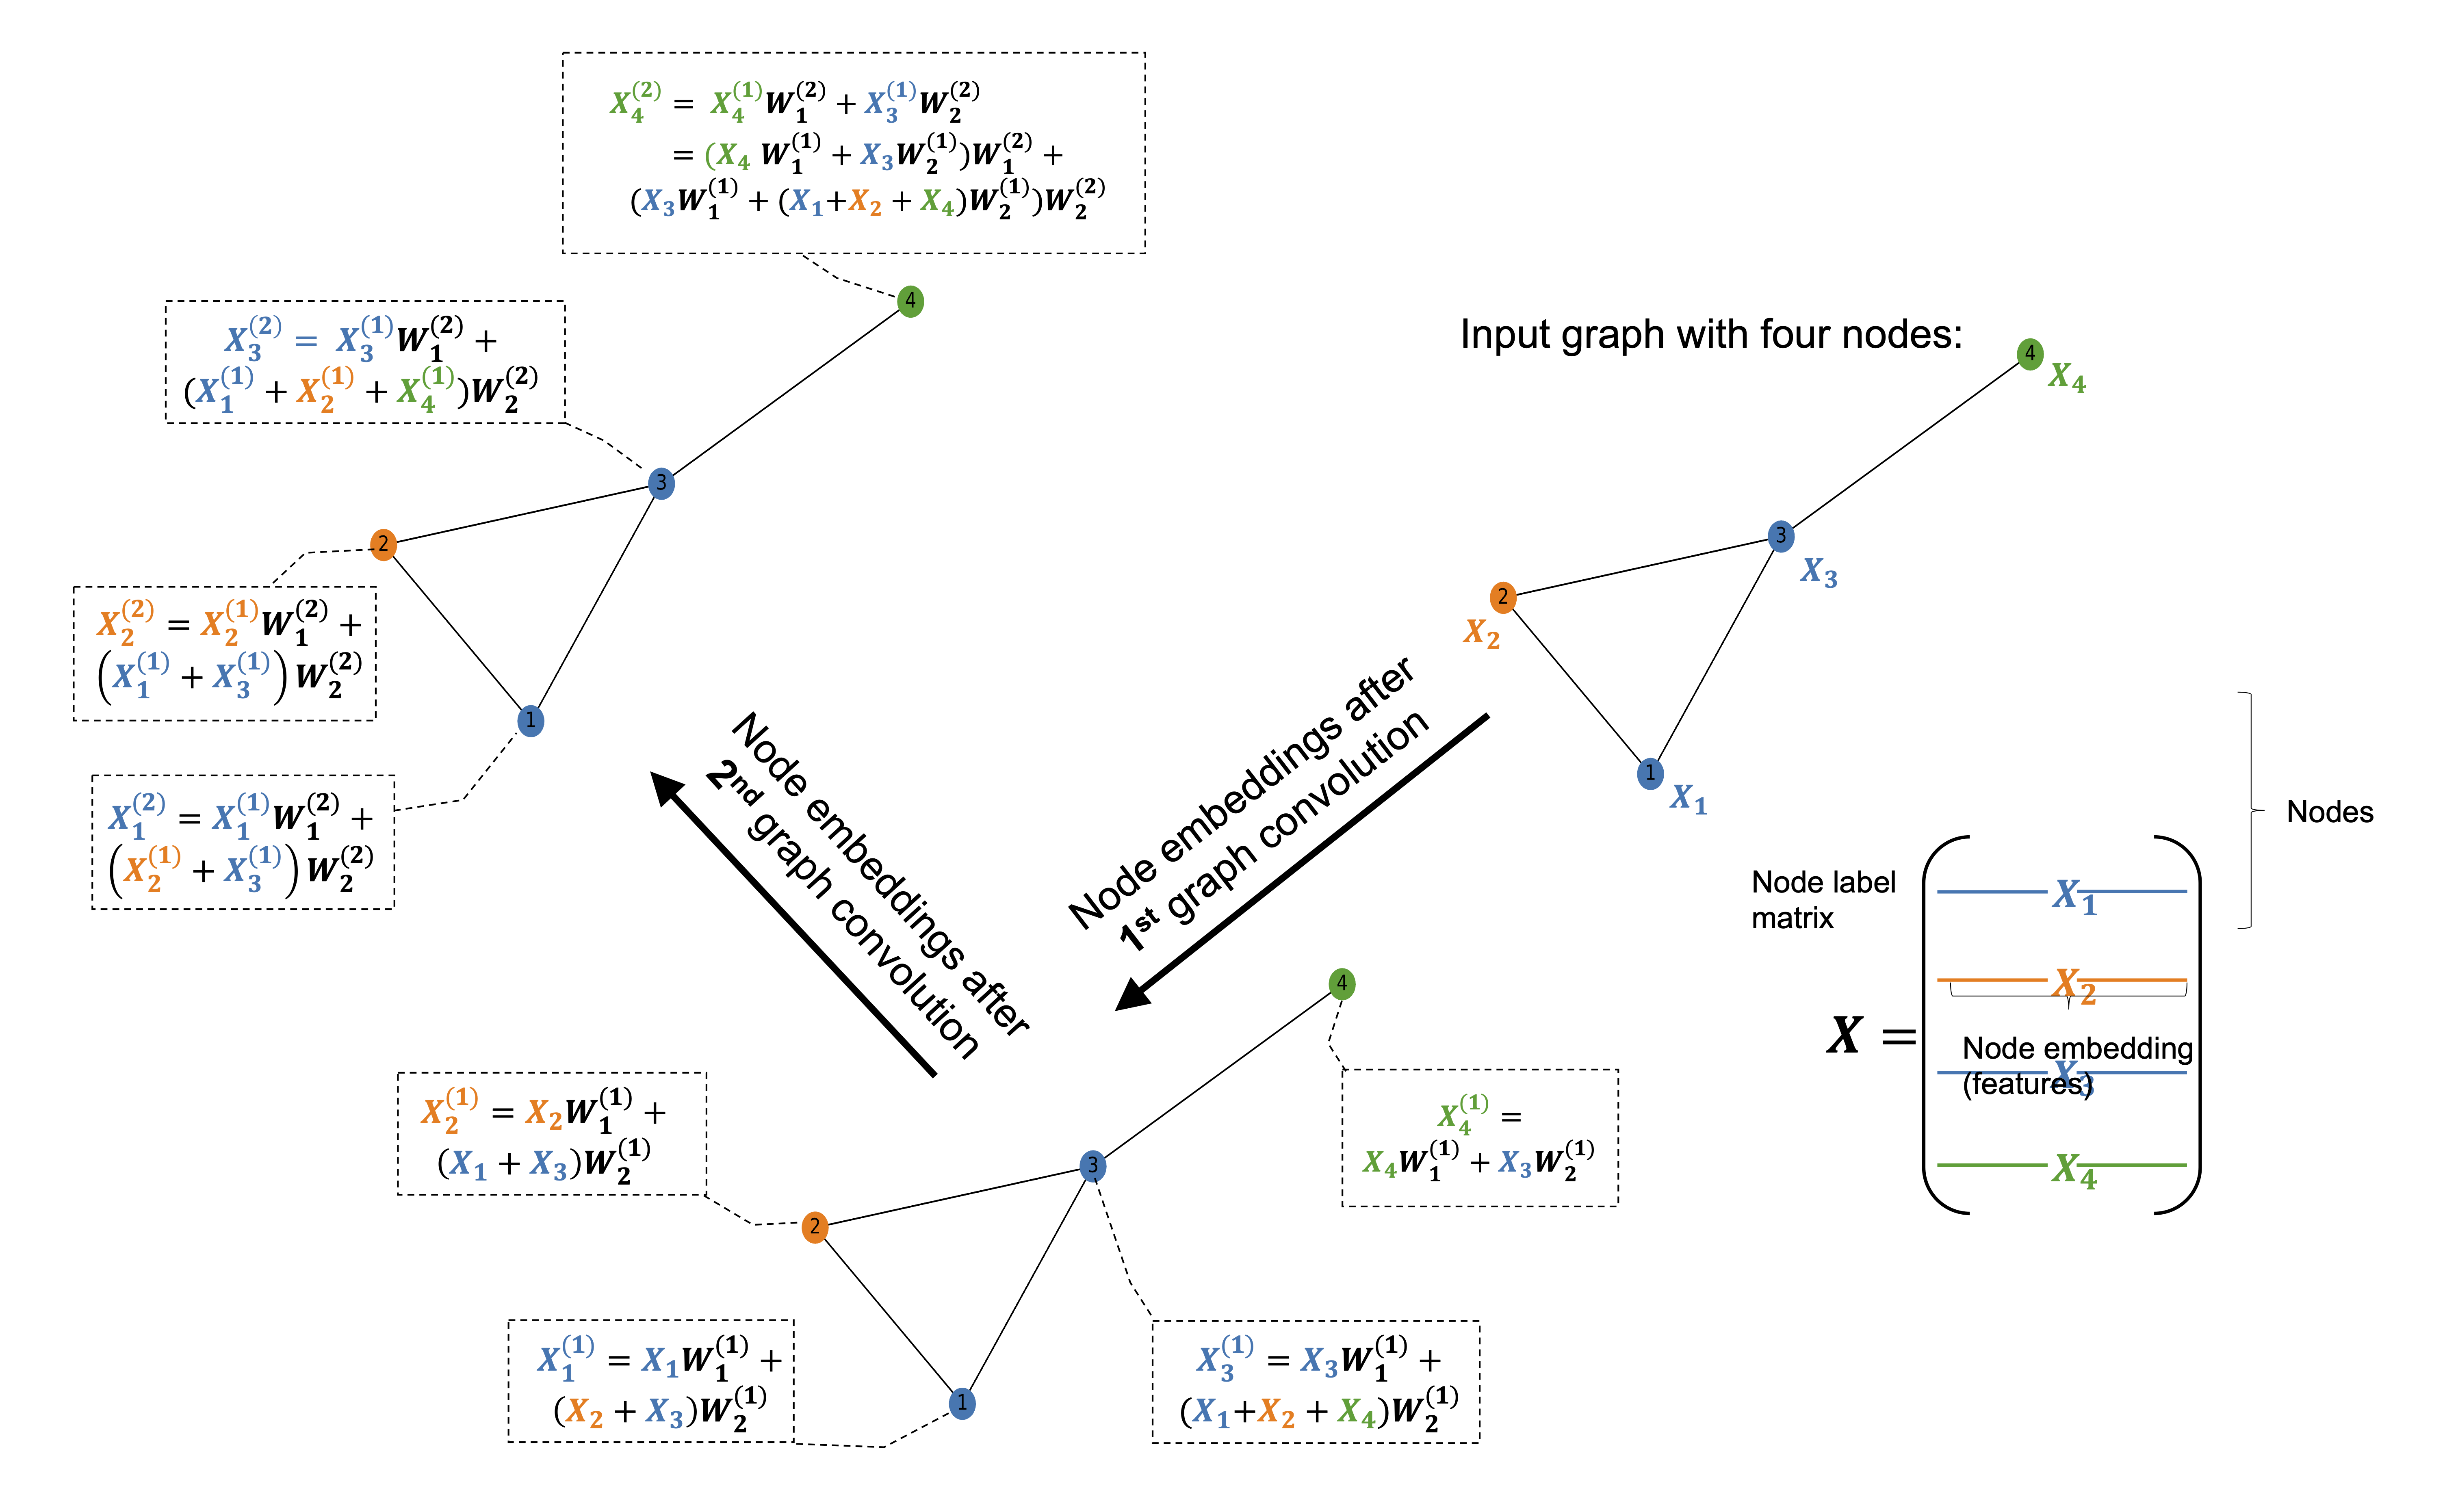

In [67]:
Image(filename="figure/18_07.png", width=1000)

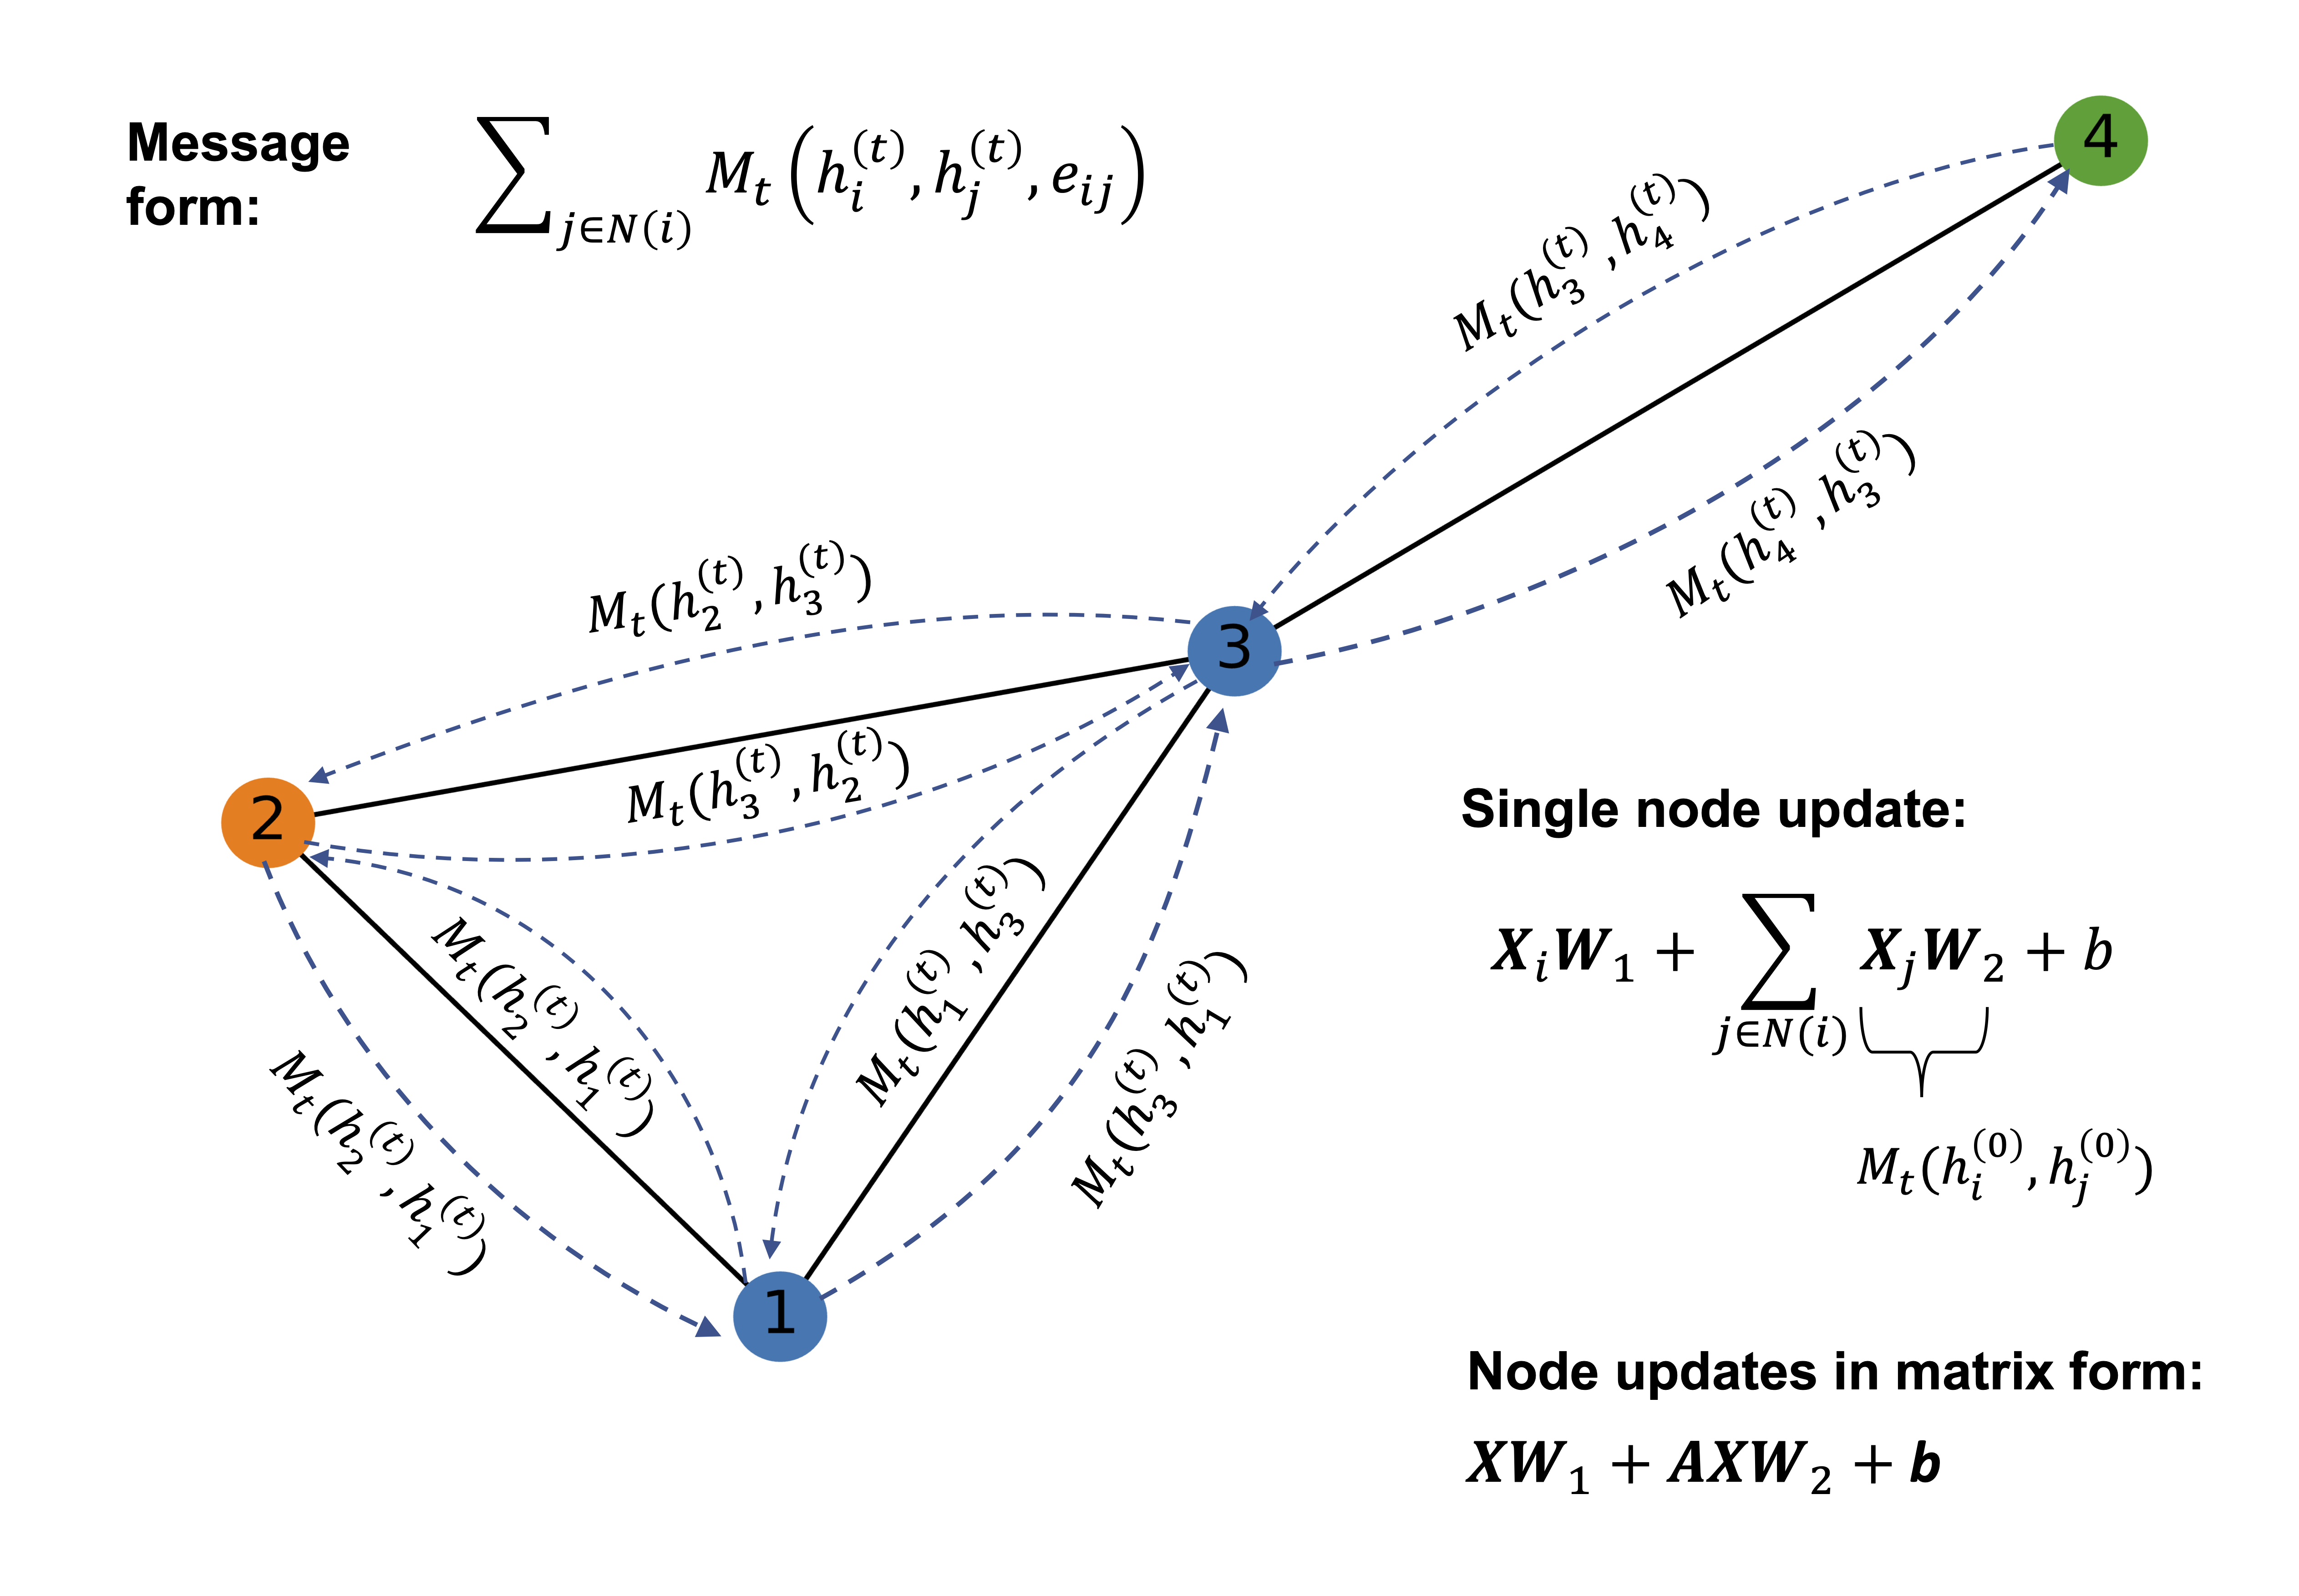

In [98]:
Image(filename="figure/18_08.png", width=900)

In [93]:
feature_in, feature_out = X.shape[1], 6  # feature dimension * new dimension
W1 = np.random.rand(feature_in, feature_out) 
W2 = np.random.rand(feature_in, feature_out)
W1.shape

(3, 6)

## For layer 1

In [88]:
np.dot(A, X)

array([[0., 1., 1.],
       [0., 2., 0.],
       [1., 1., 1.],
       [0., 1., 0.]])

In [94]:
np.dot(X, W1)

array([[0.57492109, 0.88611923, 0.33658225, 0.69218919, 0.93215735,
        0.8094962 ],
       [0.54641026, 0.10583624, 0.42677335, 0.55418507, 0.1875271 ,
        0.47873928],
       [0.57492109, 0.88611923, 0.33658225, 0.69218919, 0.93215735,
        0.8094962 ],
       [0.43712597, 0.62926246, 0.88995157, 0.75962024, 0.26215033,
        0.3959001 ]])

### Layer 1 output

In [96]:
h1 = np.dot(X, W1) + np.dot(np.dot(A, X), W2)
h1.shape

(4, 6)


# Implementing a GNN in PyTorch from scratch


In [101]:
import torch
import networkx as nx
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F
from torch import nn

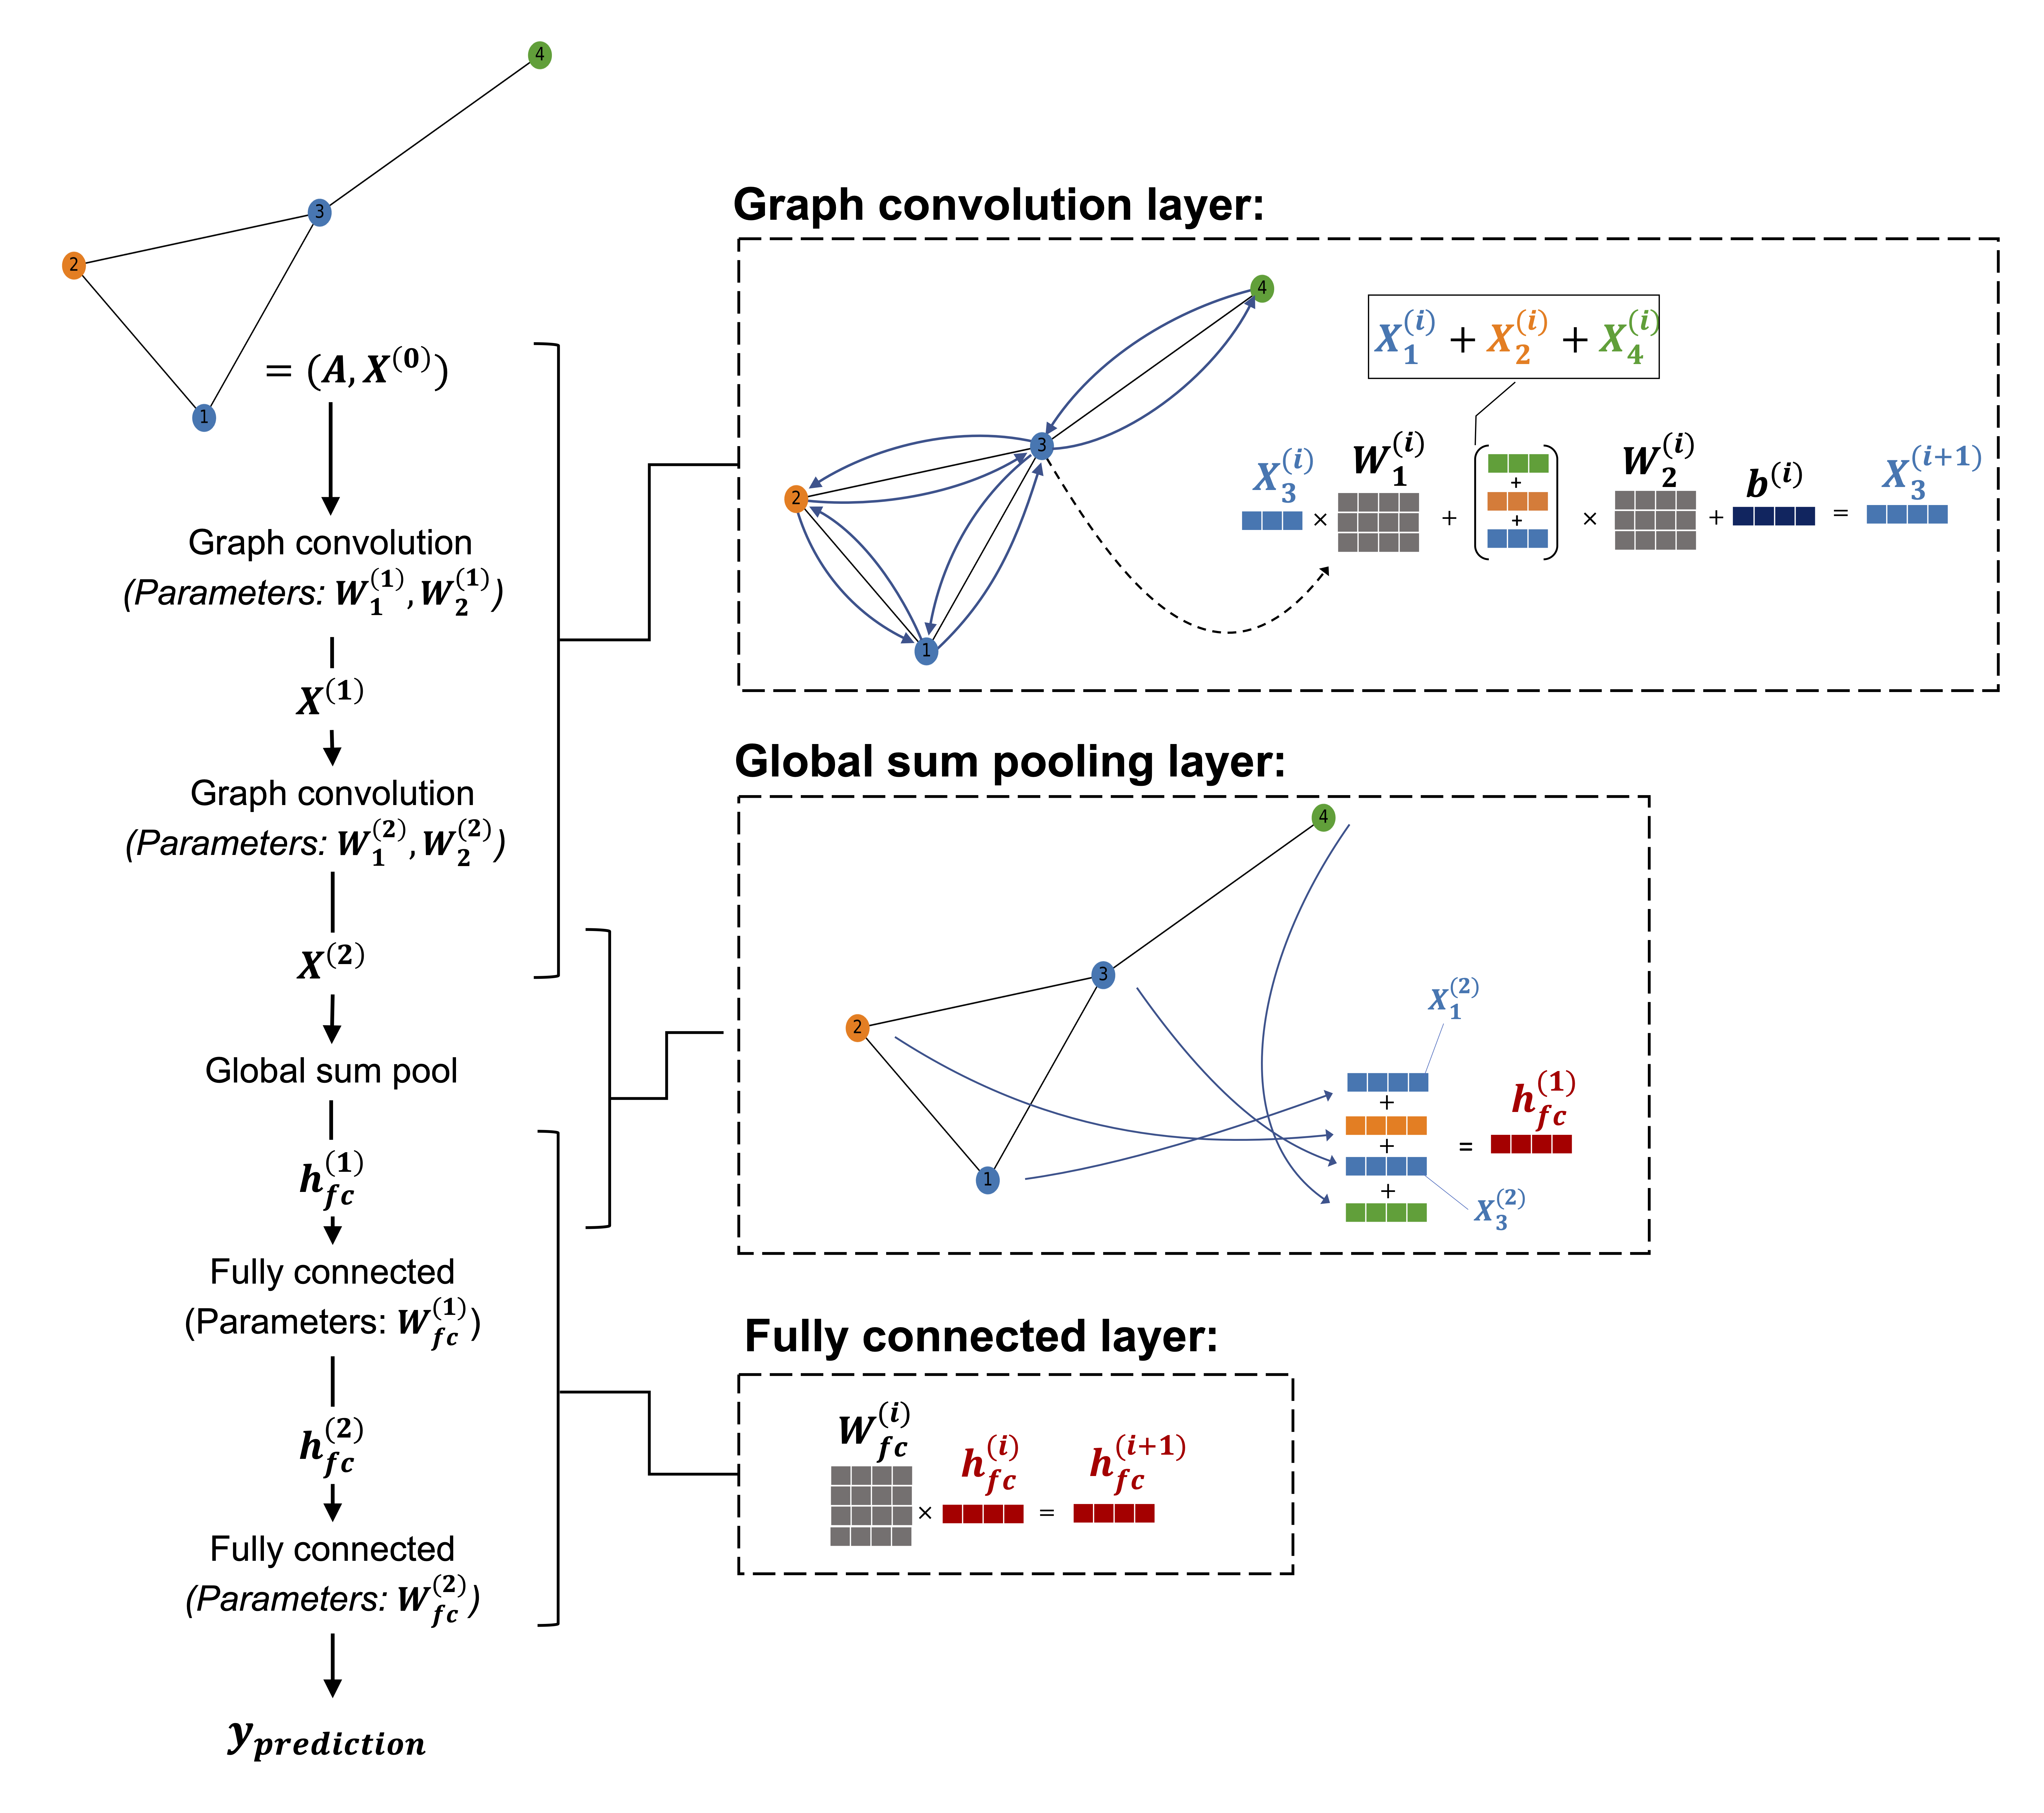

In [100]:
Image(filename='figure/18_09.png', width=700)

In [160]:
class NodeNetwork(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.g_conv1 = BasicGraphConvolution(in_features, 32)
        self.g_conv2 = BasicGraphConvolution(32, out_features)
        self.fc1 = nn.Linear(out_features, 16)
        self.out_layer = nn.Linear(16, 2)
    
    def forward(self, X, A, batch_mat):
        x = self.g_conv1(X, A).clamp(0)
        x = self.g_conv2(x, A).clamp(0)
        output = global_sum_pool(x, batch_mat)
        output = self.fc1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

## Basic Graph convolution

In [161]:
class BasicGraphConvolution(nn.Module):
    def __init__(self,  in_features, out_features):
        super().__init__()
        
        self.in_channels = in_features
        self.out_channels = out_features
        self.w1 = Parameter(torch.rand((in_features, out_features), dtype=torch.float32))
        self.w2 = Parameter(torch.rand((in_features, out_features), dtype=torch.float32))
        self.bias = Parameter(torch.zeros(out_features, dtype=torch.float32))
    
    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.w2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.w1)
        output = root_update + propagated_msgs + self.bias
        return output

## Adding a global pooling layer to deal with varying graph sizes

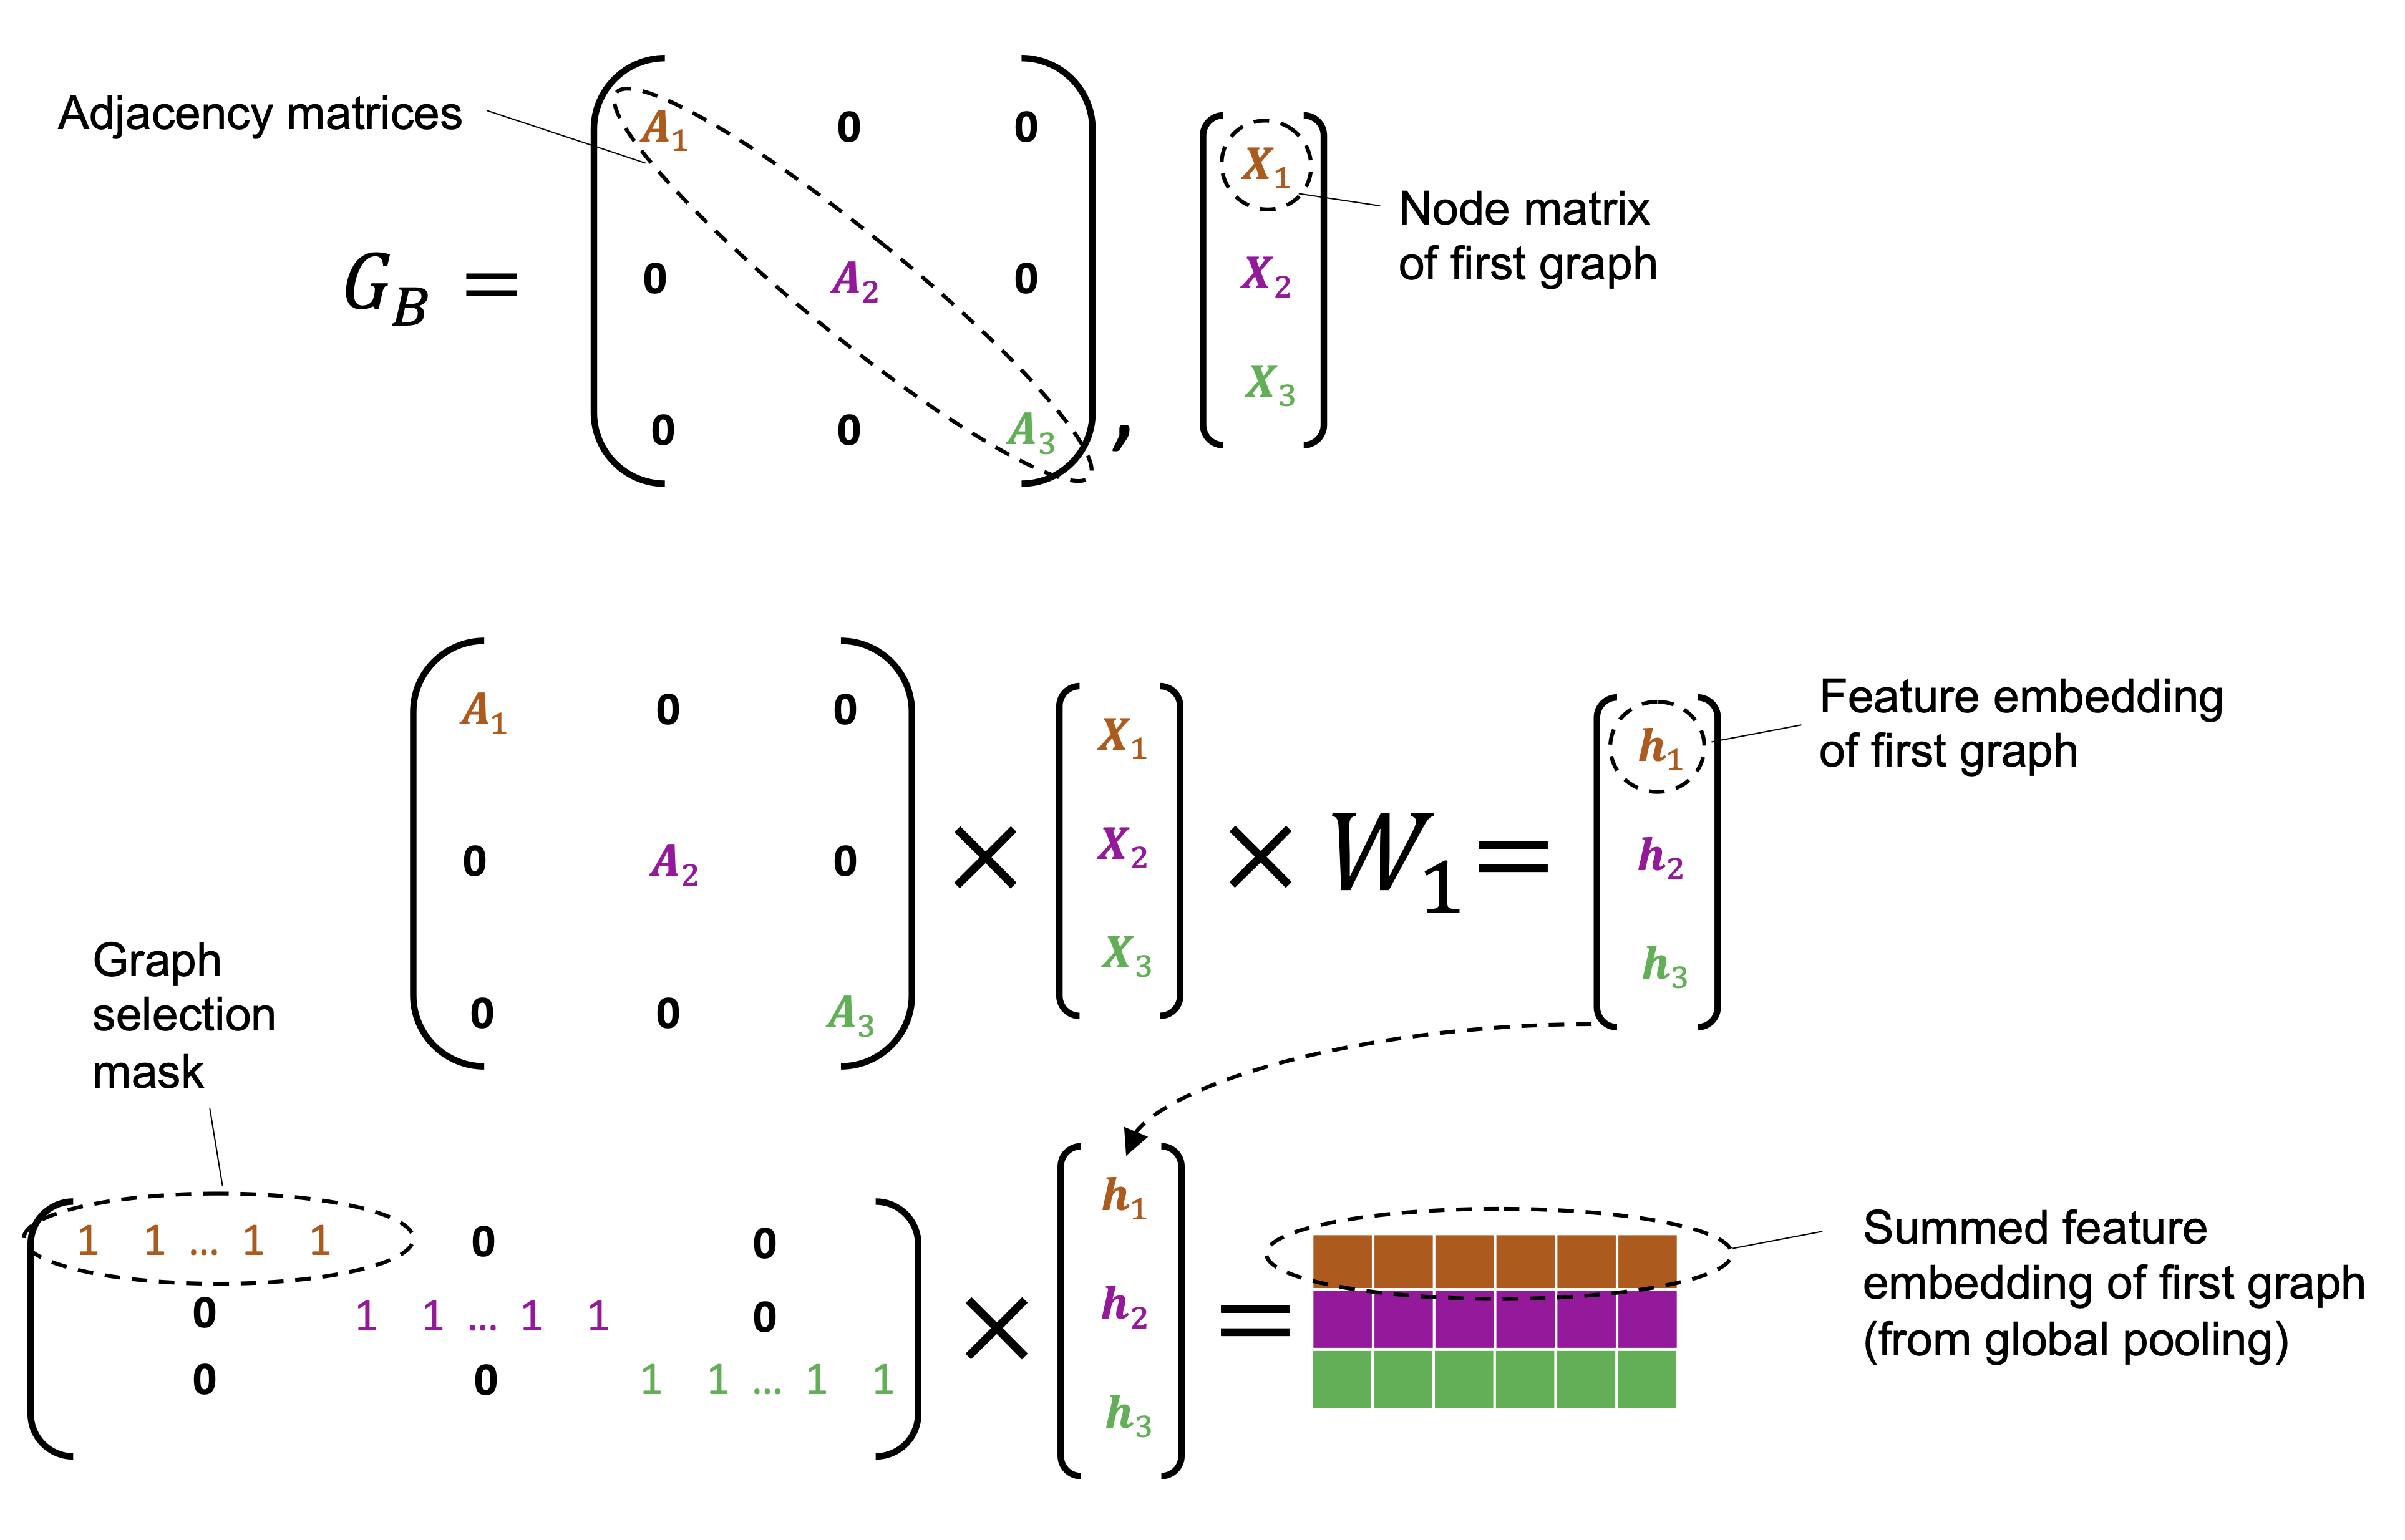

In [121]:
Image(filename='figure/18_10.png', width=800)

In [156]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [114]:
torch.mm(torch.rand(3, 6), torch.rand(6, 3)).shape

torch.Size([3, 3])

# Preparing Dataset

In [148]:
def get_graph_dict(G, mapping_dict):
    # build dictionary representation of graph G
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation() was introduced with the first example graph
    X = torch.from_numpy(get_graph_feature_matrix(G, mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1, 0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

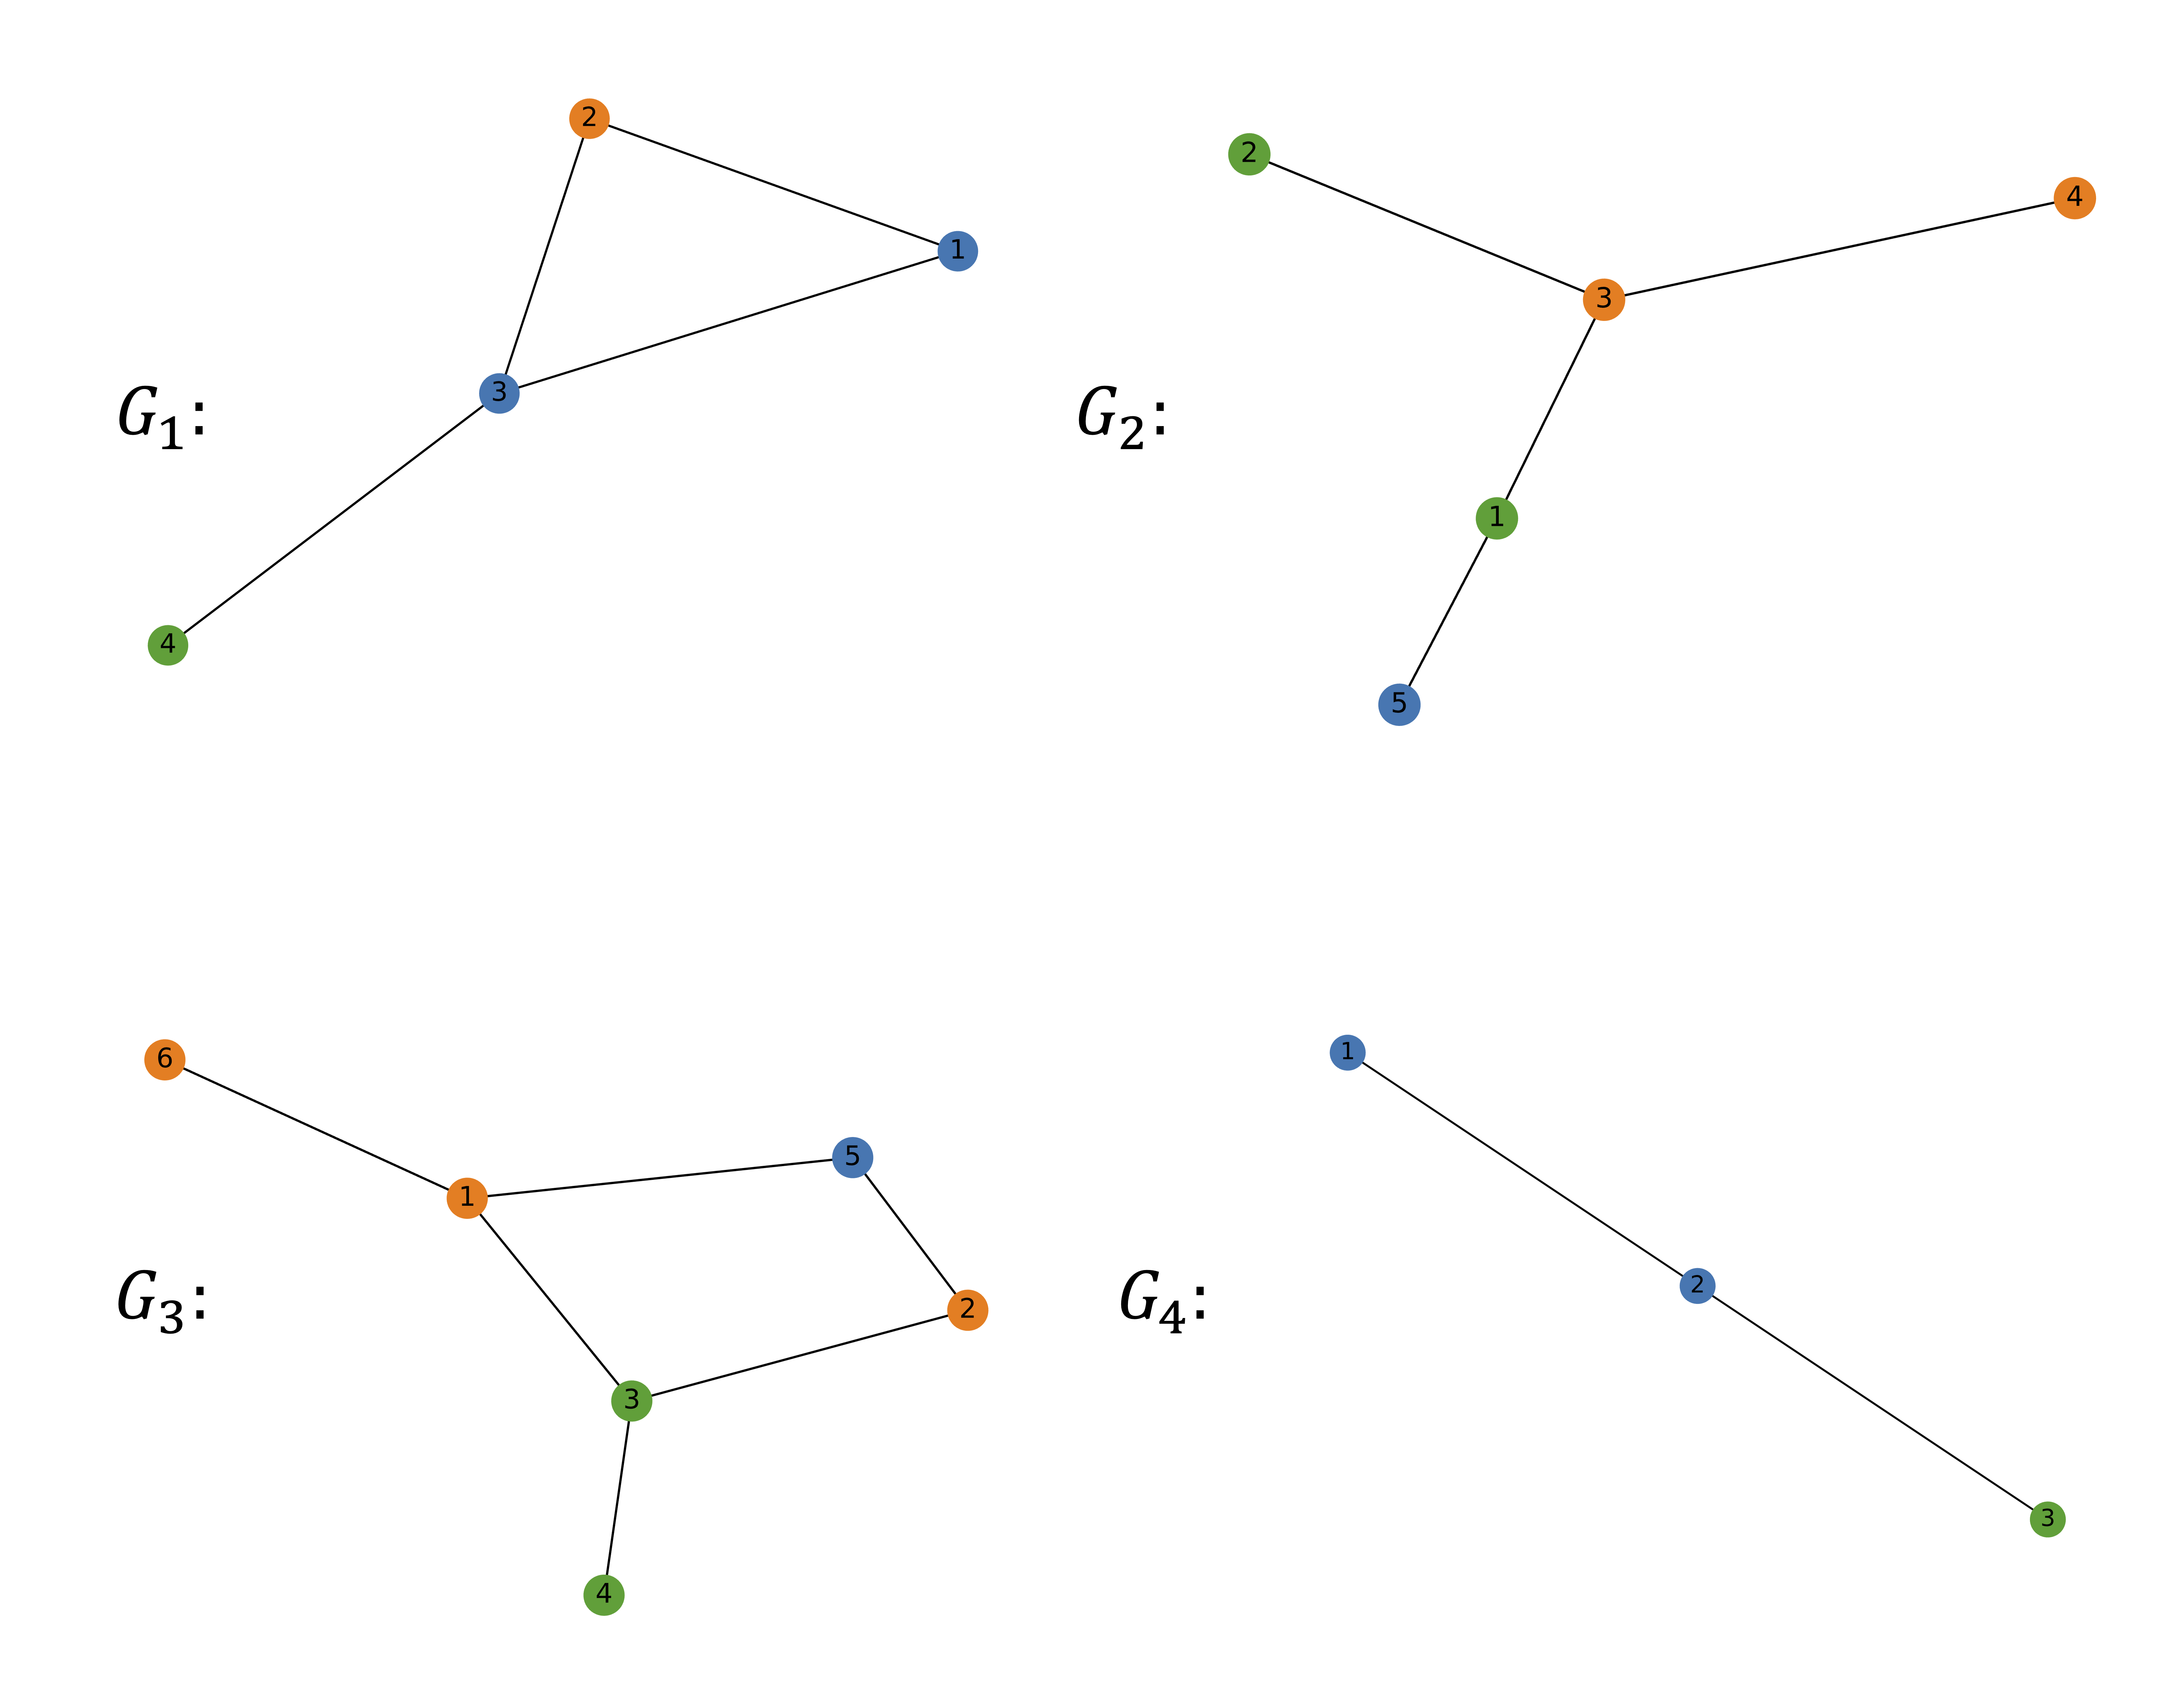

In [127]:
Image(filename='figure/18_11.png', width=600)

## Graph list

In [170]:
feature_map  = {green : 0, blue:1, orange: 2} # map a color to a index

# building 4 graphs to treat as a dataset
# G1
G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3),(1, 3), (3, 4)])

# G2
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5,{"color": blue})])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])

# G3
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color":orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])

# G4
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])

graph_list = [get_graph_dict(graph, feature_map) for graph in [G1, G2, G3, G4]]

graph_list[0]

{'A': tensor([[0., 1., 1., 0.],
         [1., 0., 1., 0.],
         [1., 1., 0., 1.],
         [0., 0., 1., 0.]]),
 'X': tensor([[0., 1., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [1., 0., 0.]]),
 'y': tensor([[1., 0.]]),
 'batch': None}

## Graph ExampleDataset


In [150]:
from torch.utils.data import DataLoader, Dataset

class ExampleDataset(Dataset):
    def __init__(self, graph_list):
        self.graphs = graph_list
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]

In [151]:
g_dataset = ExampleDataset(graph_list)
len(g_dataset)

4

## Dataloader for graph dataset

In [152]:
def get_batch_tensor(graph_sizes):
    """  
    Args:
        graph_sizes = list of the size of the graph in the batch. 
    Return:
        A tensor of size -> batch_size * sum(graph_size)

    Example 
        ```
        get_batch_tensor([6, 3])
    
        returns 
            tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0.],
                    [0., 0., 0., 0., 0., 0., 1., 1., 1.]])

        ```        
    """
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx]+graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat



def collate_graphs(batch):
    """
        why collate fn
    """
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch],dim=0)
    
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size, accum:accum+g_size] = adj
        accum = accum + g_size
        
    repr_and_label = {
            'A': batch_adj, 
            'X': feat_mats,
            'y': labels,
            'batch' : batch_mat}

    return repr_and_label

In [153]:
loader = DataLoader(g_dataset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

for b in loader:
    print(b['A'].shape, b['X'].shape, b['y'].shape, b['batch'].shape)
#     break

torch.Size([9, 9]) torch.Size([9, 3]) torch.Size([2, 2]) torch.Size([2, 9])
torch.Size([9, 9]) torch.Size([9, 3]) torch.Size([2, 2]) torch.Size([2, 9])


In [137]:
b['batch']

tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1.]])

In [138]:
b['X']

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.]])

In [141]:
b['A'] # large adjacency matrix

tensor([[0., 0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [142]:
b['y']

tensor([[1., 0.],
        [1., 0.]])

In [139]:
b['batch'] @ b['X']

tensor([[2., 1., 3.],
        [1., 2., 0.]])

# Creating GNN instance

In [162]:
torch.manual_seed(42)
node_in_features = 3
node_out_features = 5
net = NodeNetwork(node_in_features, node_out_features)

## Simple prediction

In [164]:
batch_results = []

for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

batch_results   

[tensor([[0., 1.],
         [0., 1.]]),
 tensor([[0., 1.],
         [0., 1.]])]

In [166]:
G1_rep = g_dataset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()
G1_single

tensor([[0., 1.]])

In [169]:
G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)